# Import python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import and Clean the Data

In [2]:
# %load "data_wrangling.py"


df_sp500 = pd.read_csv('data/S&P500.csv')

#Column selection
df_sp500 = df_sp500[['Date','Open', 'Close', 'Adj Close']]

#Dropping NaN values
df_sp500.dropna(axis=0, inplace=True)

#Converting dates from string to datetime
df_sp500['Date'] = pd.to_datetime(df_sp500.Date)
df_sp500.shape

(17441, 4)

# Check Head of Dataframe

In [3]:
df_sp500.head()

,Date,Open,Close,Adj Close
0,1950-01-03,16.66,16.66,16.66
1,1950-01-04,16.85,16.85,16.85
2,1950-01-05,16.93,16.93,16.93
3,1950-01-06,16.98,16.98,16.98
4,1950-01-09,17.08,17.08,17.08


# Describe the data

In [4]:
df_sp500.describe()

,Open,Close,Adj Close
count,17441.000000,17441.000000,17441.000000
mean,578.714198,578.842952,578.842952
std,690.878183,690.984350,690.984350
min,16.660000,16.660000,16.660000
25%,86.029999,86.029999,86.029999
50%,167.100006,167.119995,167.119995
75%,1098.839966,1099.229980,1099.229980
max,2936.760010,2939.879883,2939.879883


From this description we can see that the Close values and the Adj Close values average out to the be the same through time. We can also see that the Open values closely follow the Close values. We see that generally the Open values are smaller than the close values which suggests that in general the stock opens lower and closes higher. 

This makes us want to look and see if there are any values in these two columns (Close and Adj Close) that differ.

In [5]:
df_sp500.loc[df_sp500['Close'] != df_sp500['Adj Close']]

,Date,Open,Close,Adj Close


From this we see that there is no difference between the close values and the adjusted close.

# View the data

Text(0, 0.5, 'Price ($)')

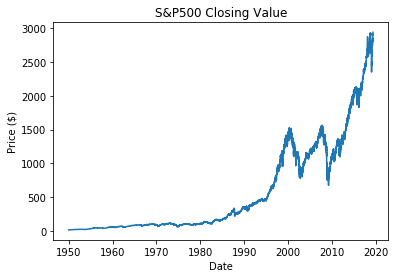

In [6]:
plt.plot(np.array(df_sp500['Date']), np.array(df_sp500['Close']))
plt.title("S&P500 Closing Value")
plt.xlabel("Date")
plt.ylabel('Price ($)')

We only model Close here because of how closely Open follows the Close price. Later we will look at the Open price in more detail.

From this graph we can see that this stock has grown over time. This makes sense since the economy has grown since the 1950s and the value of the companies that this stock measures has grown since then as well. There a few major dips in the graph which should be represenative of economic crashes. We believe this to be true due the economic crash in 2008 and the represenative fall in the graph at the same time.

# Modifing the Data

The data has an irregular date pattern. This is due to the stock market closing on weekends and holidays and so the data table has jumps in time. For example from the head of the dataframe we can clearly see that it goes from 1950-01-03 to 1950-01-04 to 1950-01-05 to 1950-01-06, but then goes to 1950-01-09. This irregularity in the date pattern messes with the granularity of the time series there isn't really a daily change going row by row. Therefore, the data had to be resampled to increase the granularity to a weekly estimate and the mean of each week is then taken.

In [30]:
df_sp500_week = df_sp500.set_index('Date')
df_sp500_week = pd.DataFrame(df_sp500_week.resample('W').mean())
df_sp500_week.head()

,Open,Close,Adj Close
Date,,,
1950-01-08,16.855,16.855,16.855
1950-01-15,16.926,16.926,16.926
1950-01-22,16.840,16.840,16.840
1950-01-29,16.814,16.814,16.814
1950-02-05,17.128,17.128,17.128


# Parameter Selection

## Order of Differencing  (d)

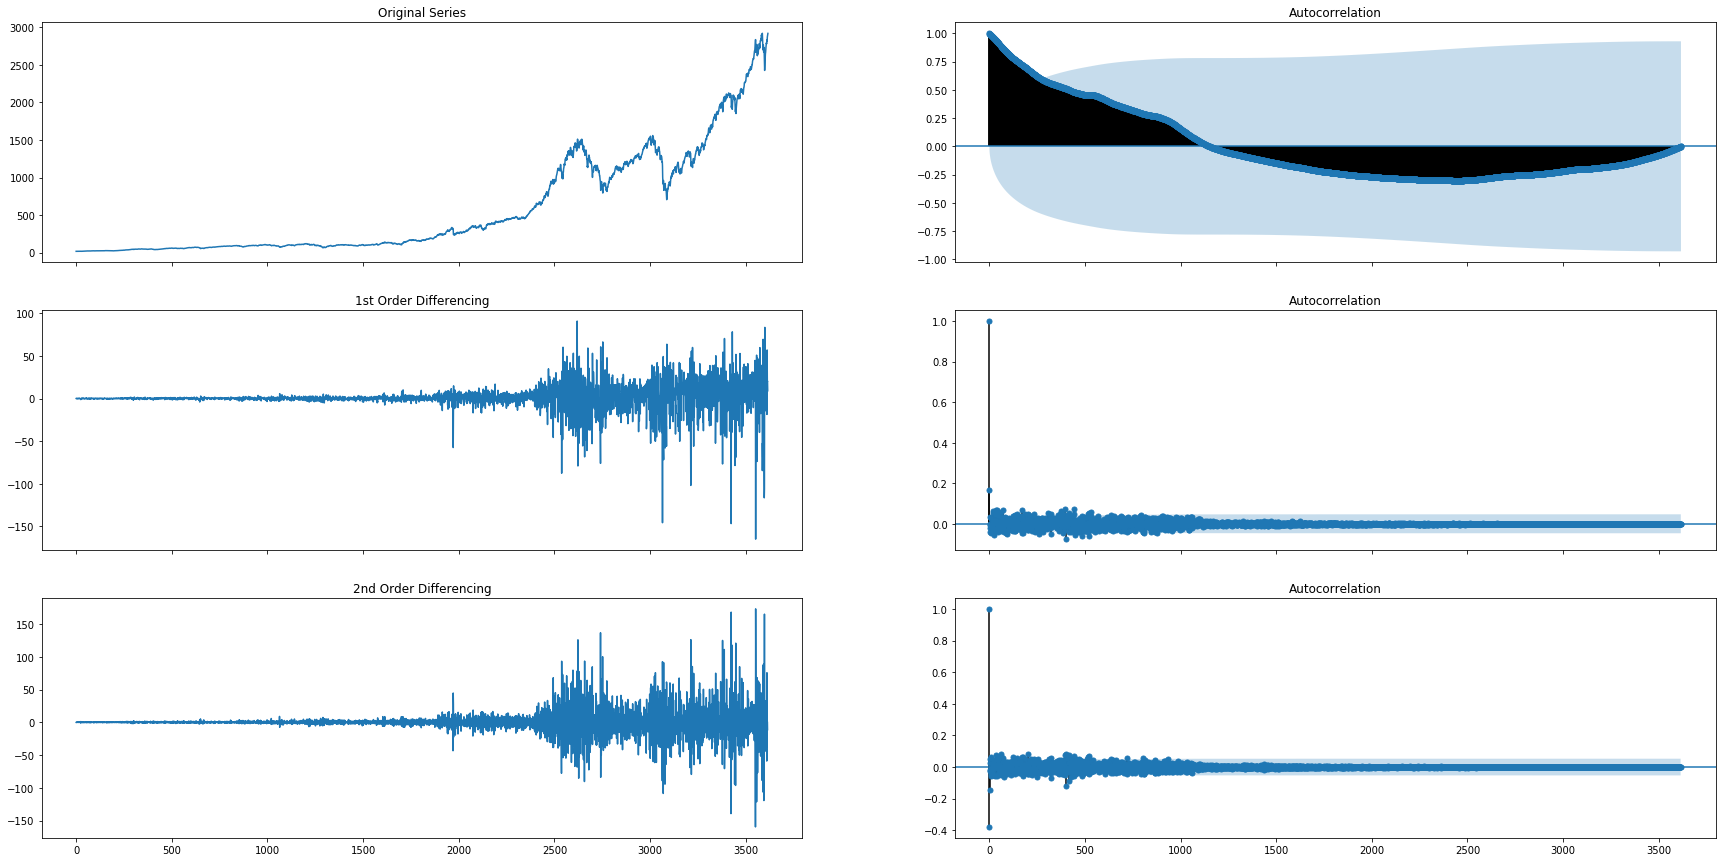

In [56]:
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(df_sp500_week['Open'].values); axes[0, 0].set_title('Original Series')
plot_acf(df_sp500_week['Open'].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df_sp500_week['Open'].values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(df_sp500_week['Open'].values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df_sp500_week['Open'].values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(df_sp500_week['Open'].values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

In [57]:
adf_dif0 = adfuller(df_sp500_week['Open'])
print('ADF Statistic: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(df_sp500_week['Open'], axis = 0))
print('ADF Statistic: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(df_sp500_week['Open'], axis = 0),axis = 0))
print('ADF Statistic: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

ADF Statistic: 2.969107 p-value: 1.000000
ADF Statistic: -9.839629 p-value: 0.000000
ADF Statistic: -18.232033 p-value: 0.000000


We do an ad-fuller test to determine whether the series is stationary, based on above, 1st order differencing is more than enough for the Open price.

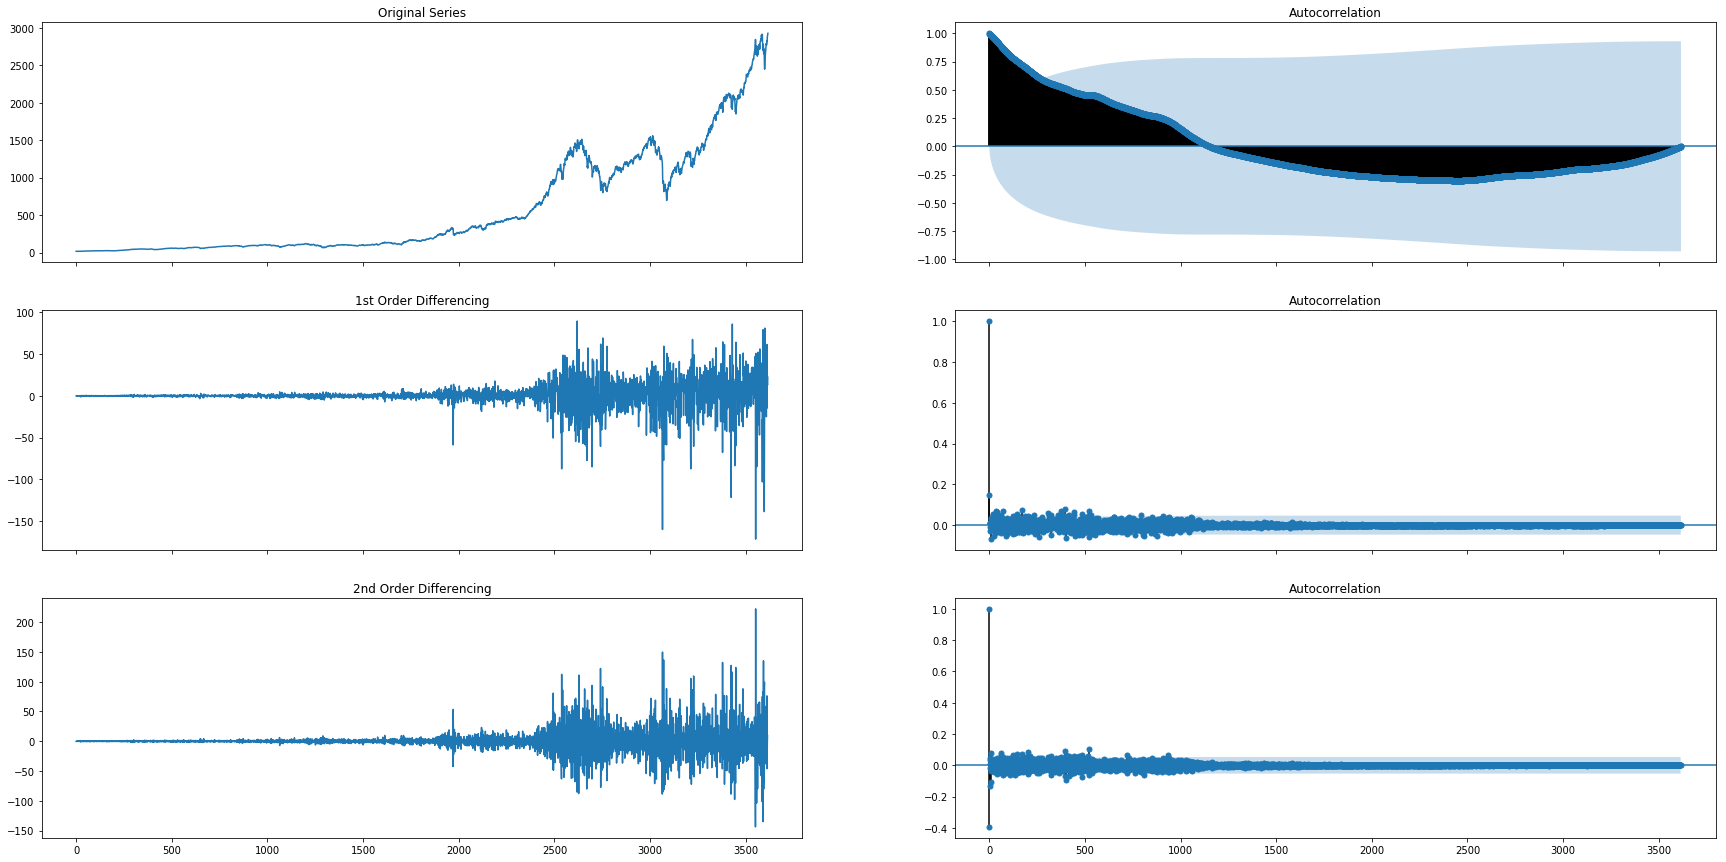

In [58]:
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(df_sp500_week['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(df_sp500_week['Close'].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df_sp500_week['Close'].values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(df_sp500_week['Close'].values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df_sp500_week['Close'].values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(df_sp500_week['Close'].values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

In [59]:
adf_dif0 = adfuller(df_sp500_week['Close'])
print('ADF Statistic: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(df_sp500_week['Close'], axis = 0))
print('ADF Statistic: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(df_sp500_week['Close'], axis = 0),axis = 0))
print('ADF Statistic: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

ADF Statistic: 3.109121 p-value: 1.000000
ADF Statistic: -10.785000 p-value: 0.000000
ADF Statistic: -17.851207 p-value: 0.000000


Similarly for Open, the 1st order derivitaive is more than enough for Close.

## Number of Lag in AR Model (p)

We plot the PACF of the 1st-differenced prices to see how well lagged observations explain variations in the data

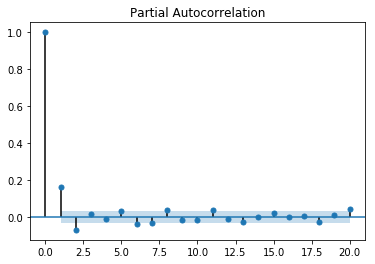

In [74]:
plot_pacf(np.diff(df_sp500_week['Open'], axis = 0), lags = 20);

We can see that 1 is above the 95% confidence interval when looking at the first dervivative of Open.

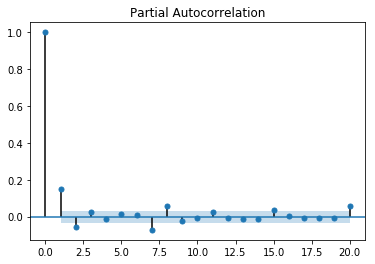

In [75]:
plot_pacf(np.diff(df_sp500_week['Close'], axis = 0), lags = 20);

We can see that 1 and 8 are above the 95% confidence interval when looking at the first dervivative of Close.

## Number of Lagged Errors in the MA model (q)

We plot ACF to see how well lagged errors explain variations in the data

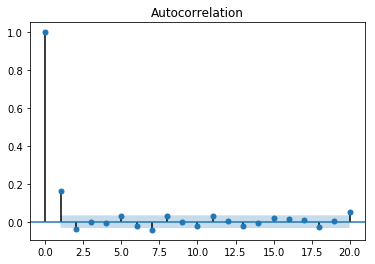

In [76]:
plot_acf(np.diff(df_sp500_week['Open'], axis = 0), lags = 20);

We can see that 1 is above the 95% confidence interval when looking at the first dervivative of Open.

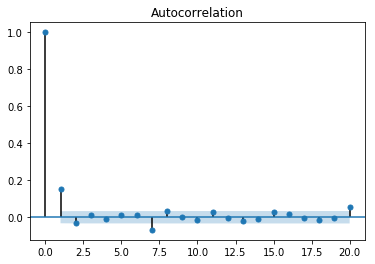

In [77]:
plot_acf(np.diff(df_sp500_week['Close'], axis = 0), lags = 20);

1 is above the 95% confidence interval when looking at the first dervivative of Close.

# ARIMA modeling

Now that we have looked at the factors that go into selecting the parameters, let's start trying to fit the data. W3 will be using p = 1, d = 1, q = 1 to model the Open price and p = 1, d = 1, q =1 to model the Close price.

## Open

In [78]:
model = ARIMA(df_sp500_week['Open'], order=np.array([1, 1, 1]), freq='W')
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 3616
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14839.597
Method:                       css-mle   S.D. of innovations             14.657
Date:                Fri, 24 May 2019   AIC                          29687.194
Time:                        16:11:06   BIC                          29711.966
Sample:                    01-15-1950   HQIC                         29696.020
                         - 04-28-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8027      0.279      2.881      0.004       0.257       1.349
ar.L1.D.Open    -0.2365      0.088     -2.703      0.007      -0.408      -0.065
ma.L1.D.Open     0.4133      0.082      5.02

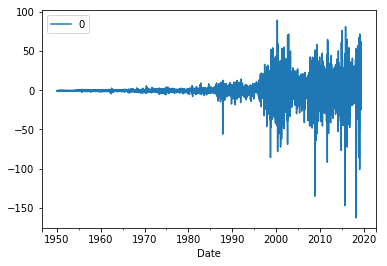

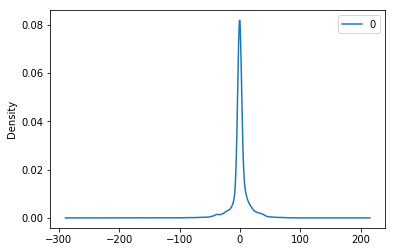

                 0
count  3616.000000
mean      0.000008
std      14.659156
min    -162.690277
25%      -2.011076
50%      -0.463446
75%       2.027552
max      89.105705


In [79]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

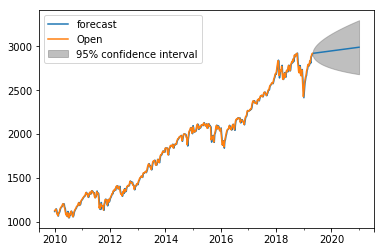

In [80]:
model_fit.plot_predict('2010', '2021', dynamic=False)
plt.show()

## Close

In [110]:
model = ARIMA(df_sp500_week['Close'], order=np.array([1, 1, 1]), freq='W')
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3616
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14845.308
Method:                       css-mle   S.D. of innovations             14.680
Date:                Fri, 24 May 2019   AIC                          29698.616
Time:                        16:17:37   BIC                          29723.389
Sample:                    01-15-1950   HQIC                         29707.443
                         - 04-28-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8053      0.276      2.917      0.004       0.264       1.347
ar.L1.D.Close    -0.2189      0.088     -2.490      0.013      -0.391      -0.047
ma.L1.D.Close     0.3786      0.083     

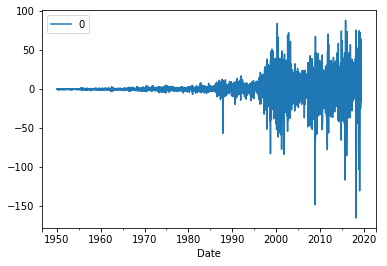

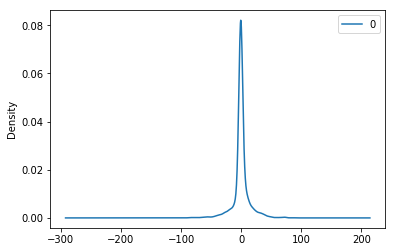

                 0
count  3616.000000
mean      0.000005
std      14.682345
min    -165.567357
25%      -1.972056
50%      -0.473427
75%       1.917833
max      87.698190


In [111]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

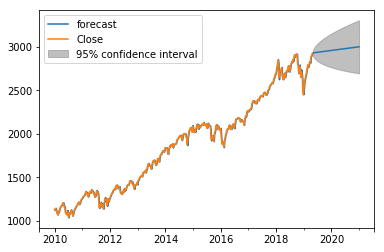

In [112]:
model_fit.plot_predict('2010', '2021', dynamic=False)
plt.show()

We can see that Open and Close data continue to follow eachother very closely with only slight differences in each of their residuals description. We can see that the ARIMA model does a good job of fitting the data, but know we need to make sure that the data isn't overfitted.

# Out of Time Cross Validation

But in order to truely test the model we need to split the data into a training set and testing set.

In [148]:
df_sp500_week_train = df_sp500_week[:int(df_sp500_week.shape[0]*.90)]
df_sp500_week_train.shape

(3255, 3)

In [149]:
df_sp500_week_test = df_sp500_week[int(df_sp500_week.shape[0]*.90):]
df_sp500_week_test.shape

(362, 3)

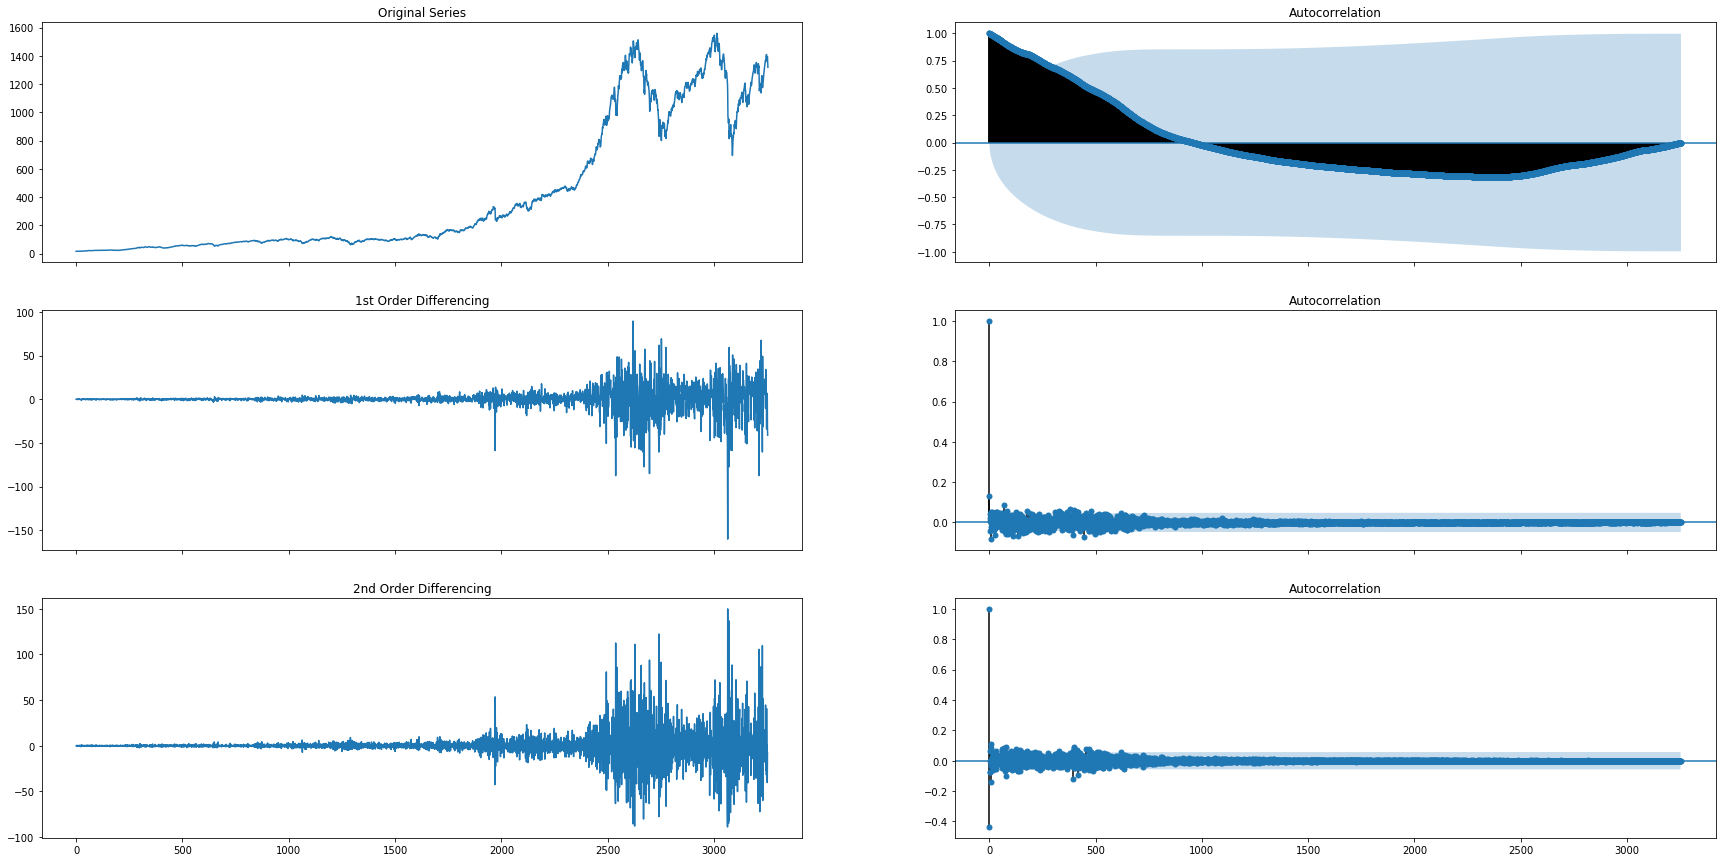

In [150]:
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(df_sp500_week_train['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(df_sp500_week_train['Close'].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df_sp500_week_train['Close'].values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(df_sp500_week_train['Close'].values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df_sp500_week_train['Close'].values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(df_sp500_week_train['Close'].values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

In [151]:
adf_dif0 = adfuller(df_sp500_week_train['Close'])
print('ADF Statistic: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(df_sp500_week_train['Close'], axis = 0))
print('ADF Statistic: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(df_sp500_week_train['Close'], axis = 0),axis = 0))
print('ADF Statistic: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

ADF Statistic: -0.125920 p-value: 0.946795
ADF Statistic: -10.330312 p-value: 0.000000
ADF Statistic: -16.458834 p-value: 0.000000


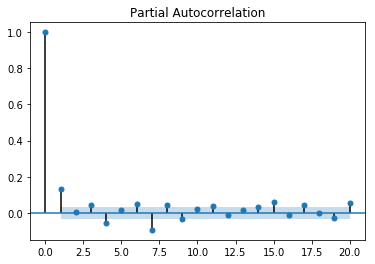

In [164]:
plot_pacf(np.diff(df_sp500_week_train['Close'].values, axis = 0), lags = 20);

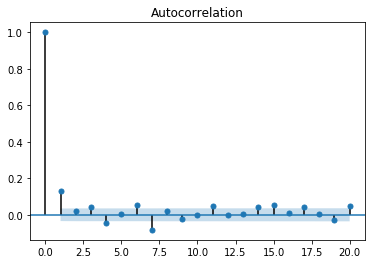

In [165]:
plot_acf(np.diff(df_sp500_week_train['Close'].values, axis = 0), lags = 20);

In [183]:
model = ARIMA(df_sp500_week_train['Close'], order=np.array([1, 2, 1]), freq='W')
model_fit = model.fit()
print (model_fit.summary())
fc, se, conf = model_fit.forecast(df_sp500_week_test.shape[0], alpha=0.05)  # 95% conf

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 3253
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -12691.268
Method:                       css-mle   S.D. of innovations             11.956
Date:                Fri, 24 May 2019   AIC                          25390.536
Time:                        16:34:06   BIC                          25414.885
Sample:                    01-22-1950   HQIC                         25399.258
                         - 05-20-2012                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.000      1.131      0.258      -0.000       0.001
ar.L1.D2.Close     0.1329      0.017      7.631      0.000       0.099       0.167
ma.L1.D2.Close    -1.0000      0.001

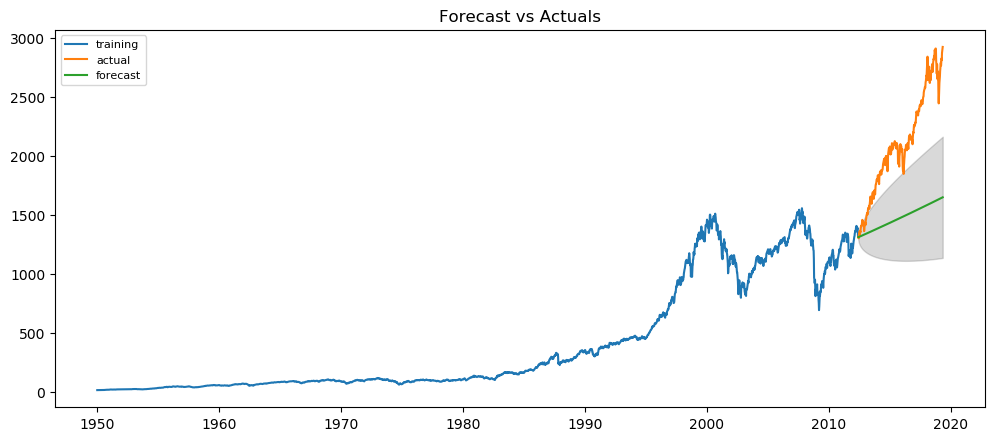

In [184]:
fc_series = pd.Series(fc, index=df_sp500_week_test.index)
lower_series = pd.Series(conf[:, 0], index=df_sp500_week_test.index)
upper_series = pd.Series(conf[:, 1], index=df_sp500_week_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_sp500_week_train['Close'], label='training')
plt.plot(df_sp500_week_test['Close'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()